In [1]:
from __future__ import print_function
import sympy
import sympy.physics.mechanics as mech
sympy.init_printing()
mech.init_vprinting()

In [112]:
t = sympy.symbols('t')
rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, \
    gyro_bias_N, gyro_bias_E, gyro_bias_D, \
    accel_bias_N, accel_bias_E, accel_bias_D, \
    pos_N, pos_E, asl, terrain_asl, baro_bias, \
    wind_N, wind_E, wind_D, d, agl, phi, theta, psi  = mech.dynamicsymbols(
    'rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, ' \
    'gyro_bias_N, gyro_bias_E, gyro_bias_D, ' \
    'accel_bias_N, accel_bias_E, accel_bias_D, ' \
    'pos_N, pos_E, asl, terrain_asl, baro_bias, ' \
    'wind_N, wind_E, wind_D, d, agl, phi, theta, psi') 
frame_i = mech.ReferenceFrame('i')
frame_n = frame_i.orientnew('n', 'Quaternion', (1, rot_N, rot_E, rot_D))
#frame_b = frame_n.orientnew('b', 'Quaternion', (q_0, q_1, q_2, q_3)) 
# easier to see where we get divide by zeros if we express dcm in euler angles
frame_b = frame_n.orientnew('b', 'Body', (psi, theta, phi), '321')
C_nb = frame_n.dcm(frame_b)
assert C_nb[0, 1] == frame_n.x.dot(frame_b.y)
sub_C_nb = {}
for i in range(3):
    for j in range(3):
        sub_C_nb[C_nb[i, j]] = sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))(t)
        sub_C_nb[-C_nb[i, j]] = -sympy.Symbol('C_nb({:d}, {:d})'.format(i, j))(t)
sub_C_nb_rev = { sub_C_nb[key]: key for key in sub_C_nb.keys() }
sub_lin = {
    rot_N: 0,
    rot_E: 0,
    rot_D: 0,
    gyro_bias_N: 0,
    gyro_bias_E: 0,
    gyro_bias_D: 0
}
sub_agl = {
    asl - terrain_asl: agl
}
omega_bx, omega_by, omega_bz = mech.dynamicsymbols('omega_bx, omega_by, omega_bz')
flowX, flowY = mech.dynamicsymbols('flowX, flowY')
omega_ib_b = omega_bx * frame_b.x \
    + omega_by * frame_b.y \
    + omega_bz * frame_b.z
gyro_bias_i = gyro_bias_N * frame_i.x \
    + gyro_bias_E * frame_i.y \
    + gyro_bias_D * frame_i.z
omega_nx, omega_ny, omega_nz = mech.dynamicsymbols('omega_nx, omega_ny, omega_nz')
omega_in_n = -gyro_bias_N * frame_n.x \
    - gyro_bias_E * frame_n.y \
    - gyro_bias_D * frame_n.z
a_N, a_E, a_D = mech.dynamicsymbols('a_N, a_E, a_D')
a_n = a_N*frame_n.x + a_E*frame_n.y + a_D*frame_n.z
a_bias_n = accel_bias_N*frame_n.x + accel_bias_E*frame_n.y + accel_bias_D*frame_n.z
a_n_correct = a_n - a_bias_n
v_i = vel_N*frame_i.x + vel_E*frame_i.y + vel_D*frame_i.z
p_i = pos_N*frame_i.x + pos_E*frame_i.y - asl*frame_i.z
I_wx, I_wy, I_wz = mech.dynamicsymbols('I_wx, I_wy, I_wz')
I_w_n = I_wx*frame_n.x + I_wy*frame_n.y  + I_wz*frame_n.z

In [113]:
xe = sympy.Matrix([rot_N, rot_E, rot_D, vel_N, vel_E, vel_D, gyro_bias_N, gyro_bias_E, gyro_bias_D,
                   accel_bias_N, accel_bias_E, accel_bias_D,
                   pos_N, pos_E, asl, terrain_asl, baro_bias, wind_N, wind_E, wind_D])
xe.T

In [114]:
def print_terms(terms):
    for t in terms:
        s = 'float {:s} = {:s};'.format(
                str(t[0]), str(t[1]))
        print(s.replace('(t)', ''))
        
def matrix_to_code(name, mat, i_name, i_syms, j_name, j_syms):
    print('Matrix<float, {:s}n, {:s}n> {:s};'.format(i_name, j_name, name))
    mat.simplify()
    terms, mat = sympy.cse(mat)
    print_terms(terms)
    mat = mat[0]
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if str(mat[i, j]) == "0":
                continue
            s = '{:s}({:s}{:s}, {:s}{:s}) = {:s};'.format(
                str(name), i_name, str(i_syms[i]),
                j_name, str(j_syms[j]), str(mat[i, j]))
            print(s.replace('(t)', ''))

## Dynamics

This is just to check the other derivaiton in IEKF Derivation notebook, doesn't match yet, needes further work.

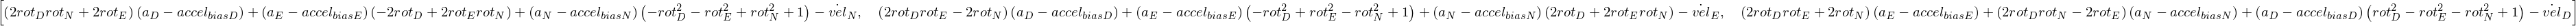

In [115]:
trans_kin_eqs = list((a_n_correct.express(frame_i) - v_i.diff(t, frame_i)).to_matrix(frame_i))
trans_kin_eqs

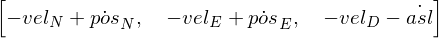

In [116]:
nav_eqs = list((p_i.diff(t, frame_i) - v_i).to_matrix(frame_i))
nav_eqs

In [117]:
sub_q = {
    (1 + rot_N**2 + rot_E**2 + rot_D**2): 1,
    2*(1 + rot_N**2 + rot_E**2 + rot_D**2): 2
}

In [118]:
rot_kin_eqs = list((frame_n.ang_vel_in(frame_i) - omega_in_n).to_matrix(frame_n))
rot_kin_eqs

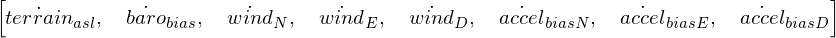

In [119]:
static_eqs = [
    terrain_asl.diff(t),
    baro_bias.diff(t),
    wind_N.diff(t),
    wind_E.diff(t),
    wind_D.diff(t),
    accel_bias_N.diff(t),
    accel_bias_E.diff(t),
    accel_bias_D.diff(t),
]
static_eqs

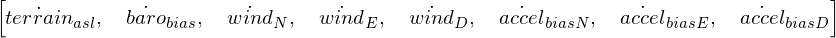

In [120]:
static_eqs

In [97]:
gyro_eqs = list((omega_in_n.diff(t, frame_n) - frame_i.ang_vel_in(frame_n).cross(I_w_n)).to_matrix(frame_n))
gyro_eqs

In [98]:
sol = sympy.solve(rot_kin_eqs + trans_kin_eqs + static_eqs + nav_eqs + gyro_eqs, xe.diff(t))
sol = { key:sol[key].subs(sub_q) for key in sol.keys() }
xe_dot = sympy.Matrix([ sol[var] for var in xe.diff(t) ]).applyfunc(lambda x: x.subs(sub_q))
#xe_dot

In [99]:
A = xe_dot.jacobian(xe).subs(sub_lin)
#A

In [100]:
matrix_to_code('A', A, 'Xe::', xe, 'Xe::', xe)

Matrix<float, Xe::n, Xe::n> A;
float x0 = 2*a_D;
float x1 = 2*accel_bias_D;
float x2 = 2*a_E;
float x3 = 2*accel_bias_E;
float x4 = 2*a_N;
float x5 = 2*accel_bias_N;
float x6 = I_wz;
float x7 = I_wy;
float x8 = I_wx;
A(Xe::rot_N, Xe::gyro_bias_N) = -1/2;
A(Xe::rot_E, Xe::gyro_bias_E) = -1/2;
A(Xe::rot_D, Xe::gyro_bias_D) = -1/2;
A(Xe::vel_N, Xe::rot_E) = x0 - x1;
A(Xe::vel_N, Xe::rot_D) = -x2 + x3;
A(Xe::vel_N, Xe::accel_bias_N) = -1;
A(Xe::vel_E, Xe::rot_N) = -x0 + x1;
A(Xe::vel_E, Xe::rot_D) = x4 - x5;
A(Xe::vel_E, Xe::accel_bias_E) = -1;
A(Xe::vel_D, Xe::rot_N) = x2 - x3;
A(Xe::vel_D, Xe::rot_E) = -x4 + x5;
A(Xe::vel_D, Xe::accel_bias_D) = -1;
A(Xe::gyro_bias_N, Xe::gyro_bias_E) = -x6;
A(Xe::gyro_bias_N, Xe::gyro_bias_D) = x7;
A(Xe::gyro_bias_E, Xe::gyro_bias_N) = x6;
A(Xe::gyro_bias_E, Xe::gyro_bias_D) = -x8;
A(Xe::gyro_bias_D, Xe::gyro_bias_N) = -x7;
A(Xe::gyro_bias_D, Xe::gyro_bias_E) = x8;
A(Xe::pos_N, Xe::vel_N) = 1;
A(Xe::pos_E, Xe::vel_E) = 1;
A(Xe::asl, Xe::vel_D) = -1;


## Airspeed

In [101]:
wind_i = wind_N*frame_i.x + wind_E*frame_i.y + wind_D*frame_i.z
vel_i = vel_N*frame_i.x + vel_E*frame_i.y + vel_D*frame_i.z

In [102]:
rel_wind = wind_i - vel_i
y_airspeed = sympy.Matrix([rel_wind.dot(-frame_b.x)]).subs(sub_C_nb)
y_airspeed

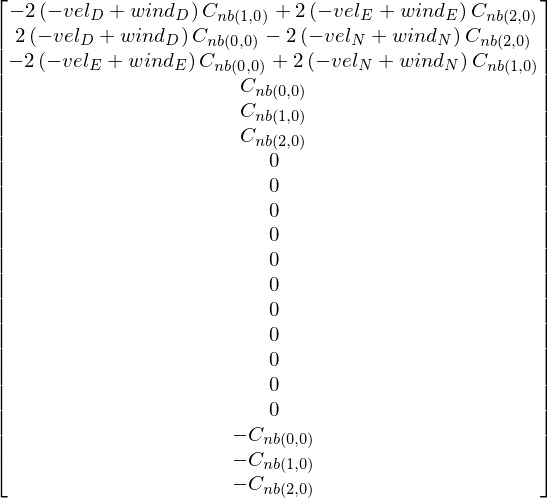

In [103]:
H_airspeed = y_airspeed.jacobian(xe).subs(sub_lin)
H_airspeed.T

In [104]:
matrix_to_code('H', H_airspeed,
               'Y_airspeed::', [sympy.Symbol('airspeed')],
               'Xe::', xe)

Matrix<float, Y_airspeed::n, Xe::n> H;
float x0 = C_nb(1, 0);
float x1 = 2*vel_D - 2*wind_D;
float x2 = C_nb(2, 0);
float x3 = 2*vel_E - 2*wind_E;
float x4 = C_nb(0, 0);
float x5 = 2*vel_N - 2*wind_N;
H(Y_airspeed::airspeed, Xe::rot_N) = x0*x1 - x2*x3;
H(Y_airspeed::airspeed, Xe::rot_E) = -x1*x4 + x2*x5;
H(Y_airspeed::airspeed, Xe::rot_D) = -x0*x5 + x3*x4;
H(Y_airspeed::airspeed, Xe::vel_N) = x4;
H(Y_airspeed::airspeed, Xe::vel_E) = x0;
H(Y_airspeed::airspeed, Xe::vel_D) = x2;
H(Y_airspeed::airspeed, Xe::wind_N) = -x4;
H(Y_airspeed::airspeed, Xe::wind_E) = -x0;
H(Y_airspeed::airspeed, Xe::wind_D) = -x2;


## Distance

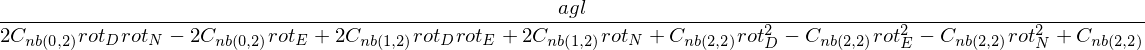

In [19]:
d_eq = sympy.solve((d*frame_b.z).dot(frame_i.z).subs(sub_C_nb) - (asl - terrain_asl), d)[0]
d_eq.subs(sub_agl)

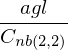

In [20]:
y_dist = sympy.Matrix([d_eq]).subs(sub_C_nb)
y_dist[0].subs(sub_lin).subs(sub_agl)

In [21]:
H_distance = y_dist.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_distance.T
matrix_to_code('H', H_distance, 'Y_distance_down::',
               [sympy.symbols('d')], 'Xe::', xe)

Matrix<float, Y_distance_down::n, Xe::n> H;
float x0 = C_nb(2, 2);
float x1 = 2*agl/x0**2;
float x2 = 1/x0;
H(Y_distance_down::d, Xe::rot_N) = -x1*C_nb(1, 2);
H(Y_distance_down::d, Xe::rot_E) = x1*C_nb(0, 2);
H(Y_distance_down::d, Xe::asl) = x2;
H(Y_distance_down::d, Xe::terrain_asl) = -x2;


## Optical Flow

In [22]:
#omega_nx, omega_ny, omega_nz = sympy.symbols('\omega_{nx}, \omega_{ny}, \omega_{nz}')
#omega_ib_n = omega_nx*frame_i.x + omega_ny*frame_i.y + omega_nz*frame_i.z
#omega_ib_n

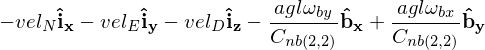

In [23]:
y_flow_sym = [flowX, flowY]
omega_n = (omega_ib_b - gyro_bias_i)
vel_f_b = -vel_i - omega_n.cross(d_eq*frame_b.z)
vel_f_b.subs(sub_lin).subs(sub_agl)

In [24]:
y_flow = sympy.Matrix([
    -vel_f_b.dot(frame_b.x).subs(sub_C_nb),
    -vel_f_b.dot(frame_b.y).subs(sub_C_nb)
    ]).subs(sub_C_nb)

In [161]:
def sym2latex(s):
    return sympy.latex(s).replace(r'{\left (t \right )}', '')

In [162]:
y_flow_lin = y_flow.subs(sub_lin).subs(sub_agl).subs(sub_C_nb)
y_flow_lin.simplify()
matrix_to_code('y_flow_lin', y_flow_lin, 'Y_flow::', y_flow_sym, '', [0])

Matrix<float, Y_flow::n, n> y_flow_lin;
float x0 = vel_N;
float x1 = vel_E;
float x2 = vel_D;
float x3 = agl/C_nb(2, 2);
y_flow_lin(Y_flow::flowX, 0) = x0*C_nb(0, 0) + x1*C_nb(1, 0) + x2*C_nb(2, 0) + x3*omega_by;
y_flow_lin(Y_flow::flowY, 0) = x0*C_nb(0, 1) + x1*C_nb(1, 1) + x2*C_nb(2, 1) - x3*omega_bx;


In [167]:
H_flow = y_flow.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_flow


for i in range(H_flow.shape[0]):
    for j in range(H_flow.shape[1]):
        if H_flow[i, j] != 0:
            s_mat = sym2latex(H_flow[i, j])
            print('H[{:s}, {:s}] =& {:s} \\\\'.format(
                sym2latex(y_flow_sym[i]),
                sym2latex(xe[j]),
                sym2latex(H_flow[i, j])))

H[\operatorname{flowX}, \operatorname{rot_{N}}] =& 2 \operatorname{C_{nb(1, 0)}} \operatorname{vel_{D}} - \frac{2 \operatorname{C_{nb(1, 2)}} \operatorname{agl}}{\operatorname{C_{nb(2, 2)}}^{2}} \omega_{by} - 2 \operatorname{C_{nb(2, 0)}} \operatorname{vel_{E}} \\
H[\operatorname{flowX}, \operatorname{rot_{E}}] =& - 2 \operatorname{C_{nb(0, 0)}} \operatorname{vel_{D}} + \frac{2 \operatorname{C_{nb(0, 2)}} \operatorname{agl}}{\operatorname{C_{nb(2, 2)}}^{2}} \omega_{by} + 2 \operatorname{C_{nb(2, 0)}} \operatorname{vel_{N}} \\
H[\operatorname{flowX}, \operatorname{rot_{D}}] =& 2 \operatorname{C_{nb(0, 0)}} \operatorname{vel_{E}} - 2 \operatorname{C_{nb(1, 0)}} \operatorname{vel_{N}} \\
H[\operatorname{flowX}, \operatorname{vel_{N}}] =& \operatorname{C_{nb(0, 0)}} \\
H[\operatorname{flowX}, \operatorname{vel_{E}}] =& \operatorname{C_{nb(1, 0)}} \\
H[\operatorname{flowX}, \operatorname{vel_{D}}] =& \operatorname{C_{nb(2, 0)}} \\
H[\operatorname{flowX}, \operatorname{gyro_{bias N}}] =& - \

In [151]:
H_flow.shape[0]

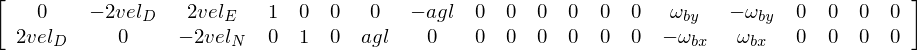

In [27]:
H_flow.subs(sub_C_nb_rev).subs({phi: 0, theta:0, psi:0})

In [28]:
P = sympy.diag(*[sympy.Symbol('var_' + str(xi)) for xi in xe])
R = sympy.diag(*[sympy.Symbol('var_flowY'), sympy.Symbol('var_flowX')])
#P = sympy.MatrixSymbol('P', len(xe), len(xe))
#R = sympy.MatrixSymbol('R', 2, 2)
S = H_flow * P * H_flow.T + R
S.simplify()

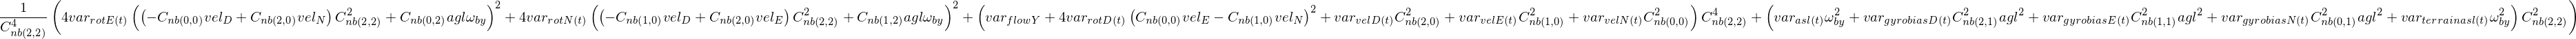

In [29]:
S[0, 0].subs(sub_agl)

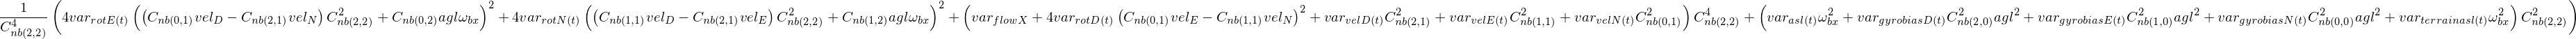

In [30]:
S[1, 1].subs(sub_agl)

In [53]:
S[0, 0].subs(sub_agl).subs(sub_C_nb_rev).subs({phi: 0, theta: 0})

In [46]:
S[1, 1].subs(sub_agl).subs(sub_C_nb_rev).subs({phi: 0, theta: 0, psi:0})

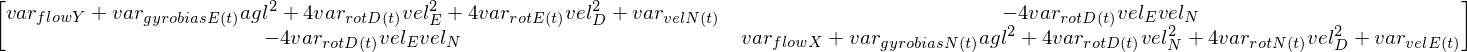

In [48]:
S.subs(sub_agl).subs(sub_C_nb_rev).subs({phi: 0, theta: 0, psi:0, omega_bx:0, omega_by: 0})

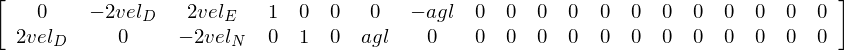

In [52]:
H_flow.subs(sub_agl).subs(sub_C_nb_rev).subs({phi: 0, theta: 0, psi:0, omega_bx:0, omega_by: 0})

In [33]:
matrix_to_code('S', sympy.diag(S[0,0]), 'Y_flow::', y_flow_sym, 'Y_flow::', y_flow_sym,)

Matrix<float, Y_flow::n, Y_flow::n> S;
float x0 = C_nb(2, 2);
float x1 = x0**4;
float x2 = agl;
float x3 = omega_by;
float x4 = x2*x3;
float x5 = x0**2;
float x6 = C_nb(0, 0);
float x7 = vel_D;
float x8 = C_nb(2, 0);
float x9 = vel_N;
float x10 = C_nb(1, 0);
float x11 = vel_E;
float x12 = x3**2;
float x13 = x2**2;
S(Y_flow::flowX, Y_flow::flowX) = (4*var_rot_E*(-x4*C_nb(0, 2) + x5*(x6*x7 - x8*x9))**2 + 4*var_rot_N*(-x4*C_nb(1, 2) + x5*(x10*x7 - x11*x8))**2 + x1*(var_flowY + 4*var_rot_D*(-x10*x9 + x11*x6)**2 + var_vel_D*x8**2 + var_vel_E*x10**2 + var_vel_N*x6**2) + x5*(var_asl*x12 + var_gyro_bias_D*x13*C_nb(2, 1)**2 + var_gyro_bias_E*x13*C_nb(1, 1)**2 + var_gyro_bias_N*x13*C_nb(0, 1)**2 + var_terrain_asl*x12))/x1;


In [34]:
matrix_to_code('H', H_flow, 'Y_flow::', y_flow_sym, 'Xe::', xe)

Matrix<float, Y_flow::n, Xe::n> H;
float x0 = vel_D;
float x1 = C_nb(1, 0);
float x2 = 2*x1;
float x3 = vel_E;
float x4 = C_nb(2, 0);
float x5 = 2*x4;
float x6 = omega_by;
float x7 = agl;
float x8 = C_nb(2, 2);
float x9 = x8**(-2);
float x10 = 2*x7*x9*C_nb(1, 2);
float x11 = C_nb(0, 0);
float x12 = 2*x11;
float x13 = vel_N;
float x14 = 2*x7*x9*C_nb(0, 2);
float x15 = C_nb(0, 1);
float x16 = 1/x8;
float x17 = x16*x7;
float x18 = C_nb(1, 1);
float x19 = C_nb(2, 1);
float x20 = x16*x6;
float x21 = 2*x18;
float x22 = 2*x19;
float x23 = omega_bx;
float x24 = 2*x15;
float x25 = x16*x23;
H(Y_flow::flowX, Xe::rot_N) = x0*x2 - x10*x6 - x3*x5;
H(Y_flow::flowX, Xe::rot_E) = -x0*x12 + x13*x5 + x14*x6;
H(Y_flow::flowX, Xe::rot_D) = x12*x3 - x13*x2;
H(Y_flow::flowX, Xe::vel_N) = x11;
H(Y_flow::flowX, Xe::vel_E) = x1;
H(Y_flow::flowX, Xe::vel_D) = x4;
H(Y_flow::flowX, Xe::gyro_bias_N) = -x15*x17;
H(Y_flow::flowX, Xe::gyro_bias_E) = -x17*x18;
H(Y_flow::flowX, Xe::gyro_bias_D) = -x17*x19;
H(Y_flow::flo

## Attitude

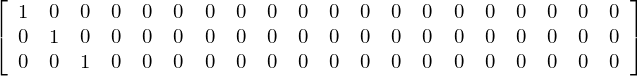

In [35]:
y_attitude = sympy.Matrix([
        rot_N, rot_E, rot_D
    ])
H_attitude = y_attitude.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_attitude

## Accelerometer

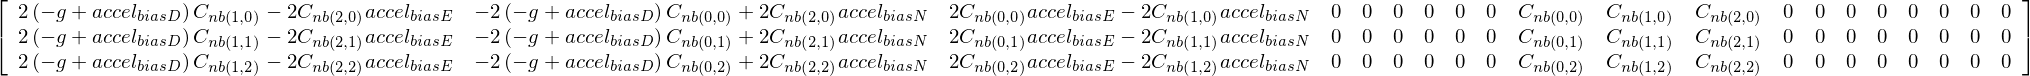

In [36]:
g = sympy.symbols('g')
g_i = -g*frame_i.z + accel_bias_N*frame_i.x + accel_bias_E*frame_i.y + accel_bias_D*frame_i.z
y_accel = sympy.Matrix(g_i.express(frame_b).subs(sub_C_nb).to_matrix(frame_b))
H_accel = y_accel.jacobian(xe).subs(sub_lin)
H_accel

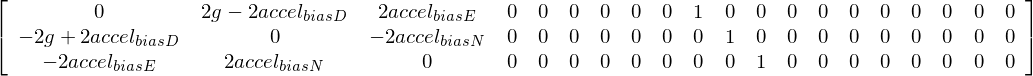

In [37]:
H_accel.subs(sub_C_nb_rev).subs({phi: 0, theta: 0, psi: 0})

## Magnetometer

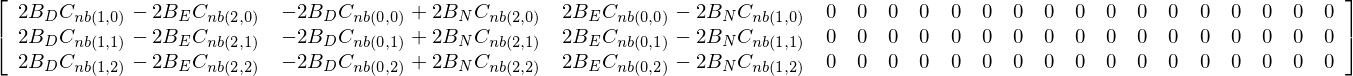

In [38]:
B_N, B_E, B_D = sympy.symbols('B_N, B_E, B_D')
b_i = B_N*frame_i.x + B_E*frame_i.y + B_D*frame_i.z
y_mag = sympy.Matrix(b_i.express(frame_b).subs(sub_C_nb).to_matrix(frame_b))
H_mag = y_mag.jacobian(xe).subs(sub_lin).subs(sub_agl)
H_mag.simplify()
H_mag

## Observability Analysis

In [39]:
def find_observable_states(H, x, n_max=3):
    O = sympy.Matrix(H)
    for n in range(n_max):
        O = O.col_join(H*A**n)
    return [x[i] for i in O.rref()[1]]

In [40]:
find_observable_states(H_mag, xe)

In [41]:
find_observable_states(H_accel, xe)

In [42]:
find_observable_states(H_mag.col_join(H_accel), xe)